In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve, auc
import joblib
import shap
import matplotlib.pyplot as plt 
import seaborn as sns

In [4]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.0/532.0 kB 1.6 MB/s eta 0:00:00-:--:--

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
data = pd.read_csv('depression_anxiety_data.csv')

In [7]:
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    data[column].fillna(data[column].mean(), inplace=True)

for column in data.select_dtypes(include=['object']).columns:
    data[column].fillna(data[column].mode()[0], inplace=True)


/var/folders/4c/hcwshm_j7kx4s87ds7k19vdr0000gn/T/ipykernel_73299/3614670353.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mean(), inplace=True)
/var/folders/4c/hcwshm_j7kx4s87ds7k19vdr0000gn/T/ipykernel_73299/3614670353.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

In [8]:
data['depression_severity'].unique()

array(['Mild', 'Moderately severe', 'None-minimal', 'Moderate', 'Severe',
       'none'], dtype=object)

In [9]:
data['anxiety_severity'].unique()

array(['Moderate', 'Mild', 'Severe', 'None-minimal', '0'], dtype=object)

In [10]:
scaler = StandardScaler()
numerical_features = ['school_year','age', 'bmi', 'phq_score', 'gad_score','epworth_score']  
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [11]:
label_encoder = LabelEncoder()
data['gender'] = label_encoder.fit_transform(data['gender'])


In [12]:
original_labels = label_encoder.classes_  
encoded_labels = range(len(original_labels))

for original, encoded in zip(original_labels, encoded_labels):
    print(f"Original: {original} -> Encoded: {encoded}")

Original: female -> Encoded: 0
Original: male -> Encoded: 1


In [13]:

data['anxiety_severity'] = pd.Categorical(data['anxiety_severity'], 
                                           categories=['0','None-minimal', 'Mild', 'Moderate', 'Severe'], 
                                           ordered=True)
data['anxiety_severity'] = data['anxiety_severity'].cat.codes


In [14]:
data['anxiety_severity'].unique()

array([3, 2, 4, 1, 0], dtype=int8)

In [15]:
depression_features = ['age', 'gender', 'bmi', 'phq_score', 'anxiety_severity','epworth_score','gad_score']
X_depression = data[depression_features]
y_depression = data['depression_severity']

In [16]:
X_depression

,age,gender,bmi,phq_score,anxiety_severity,epworth_score,gad_score
0,-0.698559,1,2.173519,0.424101,3,0.156849,0.886690
1,-1.264782,1,-0.784803,0.198049,2,1.918561,-0.383331
2,-0.698559,1,0.368771,0.198049,2,-0.094824,-0.171661
3,-1.264782,0,0.069754,2.684625,4,1.163542,1.733370
4,-1.264782,1,0.481668,-0.254056,3,-0.849843,1.521700
...,...,...,...,...,...,...,...
778,2.132557,0,-0.509644,-0.254056,1,-0.849843,-1.230012
779,1.000111,1,0.413994,-0.706161,2,-0.849843,-0.171661
780,1.000111,1,-0.153505,-1.158266,2,-0.598170,-0.383331
781,1.000111,0,-0.084935,2.232521,4,2.170234,2.580051


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_depression, y_depression, test_size=0.2, random_state=42)


In [18]:
depression_model = RandomForestClassifier(random_state=42)
depression_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [19]:
y_pred = depression_model.predict(X_test)
print("Depression Severity Detection:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
accuracy_score(y_test,y_pred)

Depression Severity Detection:
[[66  0  0  0  0  0]
 [ 0 24  0  0  0  0]
 [ 0  1 12  0  0  0]
 [ 0  0  0 50  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  1  0  2]]
                   precision    recall  f1-score   support

             Mild       1.00      1.00      1.00        66
         Moderate       0.96      1.00      0.98        24
Moderately severe       1.00      0.92      0.96        13
     None-minimal       0.98      1.00      0.99        50
           Severe       1.00      1.00      1.00         1
             none       1.00      0.67      0.80         3

         accuracy                           0.99       157
        macro avg       0.99      0.93      0.95       157
     weighted avg       0.99      0.99      0.99       157



0.9872611464968153

In [20]:
y_pred_proba = depression_model.predict_proba(X_test)[:, 1]  
pos_label = ['Severe'][0]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=pos_label)  #
roc_auc = auc(fpr, tpr)

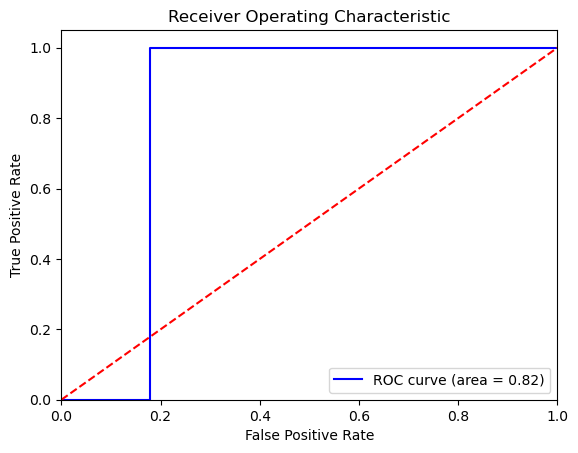

In [21]:
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [22]:
importances = depression_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': depression_features,
    'Importance': importances
})

In [23]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
3,phq_score,0.688664
6,gad_score,0.103693
2,bmi,0.068966
5,epworth_score,0.054448
4,anxiety_severity,0.040711
0,age,0.032137
1,gender,0.011380


In [24]:
import joblib

joblib.dump(depression_model, 'depression_model.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [25]:
def shap_analysis(model, input_data):

    explainer = shap.TreeExplainer(model)

    # Calculate SHAP values
    shap_values = explainer.shap_values(input_data)

    if isinstance(shap_values, list):
        shap_values = shap_values[0] 

    # Convert input_data to DataFrame
    input_df = pd.DataFrame(input_data, columns=[
        'Age', 'Gender', 'BMI', 'PHQ Score', 'Anxiety Severity', 'Epworth Score', 'GAD Score'
    ])

    shap.summary_plot(shap_values, input_df)

In [26]:
def predict_anxiety_severity():
    # Load the saved model and label encoder
    depression_model = joblib.load('depression_model.pkl')
    label_encoder = joblib.load('label_encoder.pkl')
    
    try:
        age = float(input("Enter age: "))
        gender = input("Enter gender (male/female): ")
        bmi = float(input("Enter BMI: "))
        phq_score = float(input("Enter PHQ Score: "))
        anxiety_severity = input("Enter Anxiety Severity: ")
        epworth_score = float(input("Enter epworth Score: "))
        gad_score = float(input("Enter gad Score: "))
    except ValueError:
        print("Error: Please enter valid numerical values for age, BMI, and PHQ Score.")
        return
    
    input_data = np.array([[age, gender, bmi, phq_score, anxiety_severity,epworth_score,gad_score]], dtype=float)
    
    # Make prediction
    prediction = depression_model.predict(input_data)

    
    print(f"Predicted Anxiety Severity: {prediction[0]}")

    input_data = input_data.reshape(1, -1)
    shap_analysis(depression_model, input_data)


In [27]:
predict_anxiety_severity()

Error: Please enter valid numerical values for age, BMI, and PHQ Score.
